In [67]:
###-------------------------------------------------------
###            set up environment 
###-------------------------------------------------------
import os
import sys
sys.path.append("/home/hieu.tranlm/sample_model/")
os.chdir("/home/hieu.tranlm/sample_model/")

### 1. Import and check data

In [68]:
import pandas as pd
data = pd.read_csv('hmeq.csv', header = 0, sep = ',')

In [69]:
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


<span style="color:red">
<ul>The mean of BAD is the ratio of bad debt contracts, at 19.95%</ul>
<ul>=> Need to check the distribution of each variables</ul>
</span>

### Check Normal Distribution for each variables by visualization

/tmp/ipykernel_1828/1889113308.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
/tmp/ipykernel_1828/1889113308.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
/tmp/ipykernel_1828/1889113308.py:10: UserWarning: 

`di

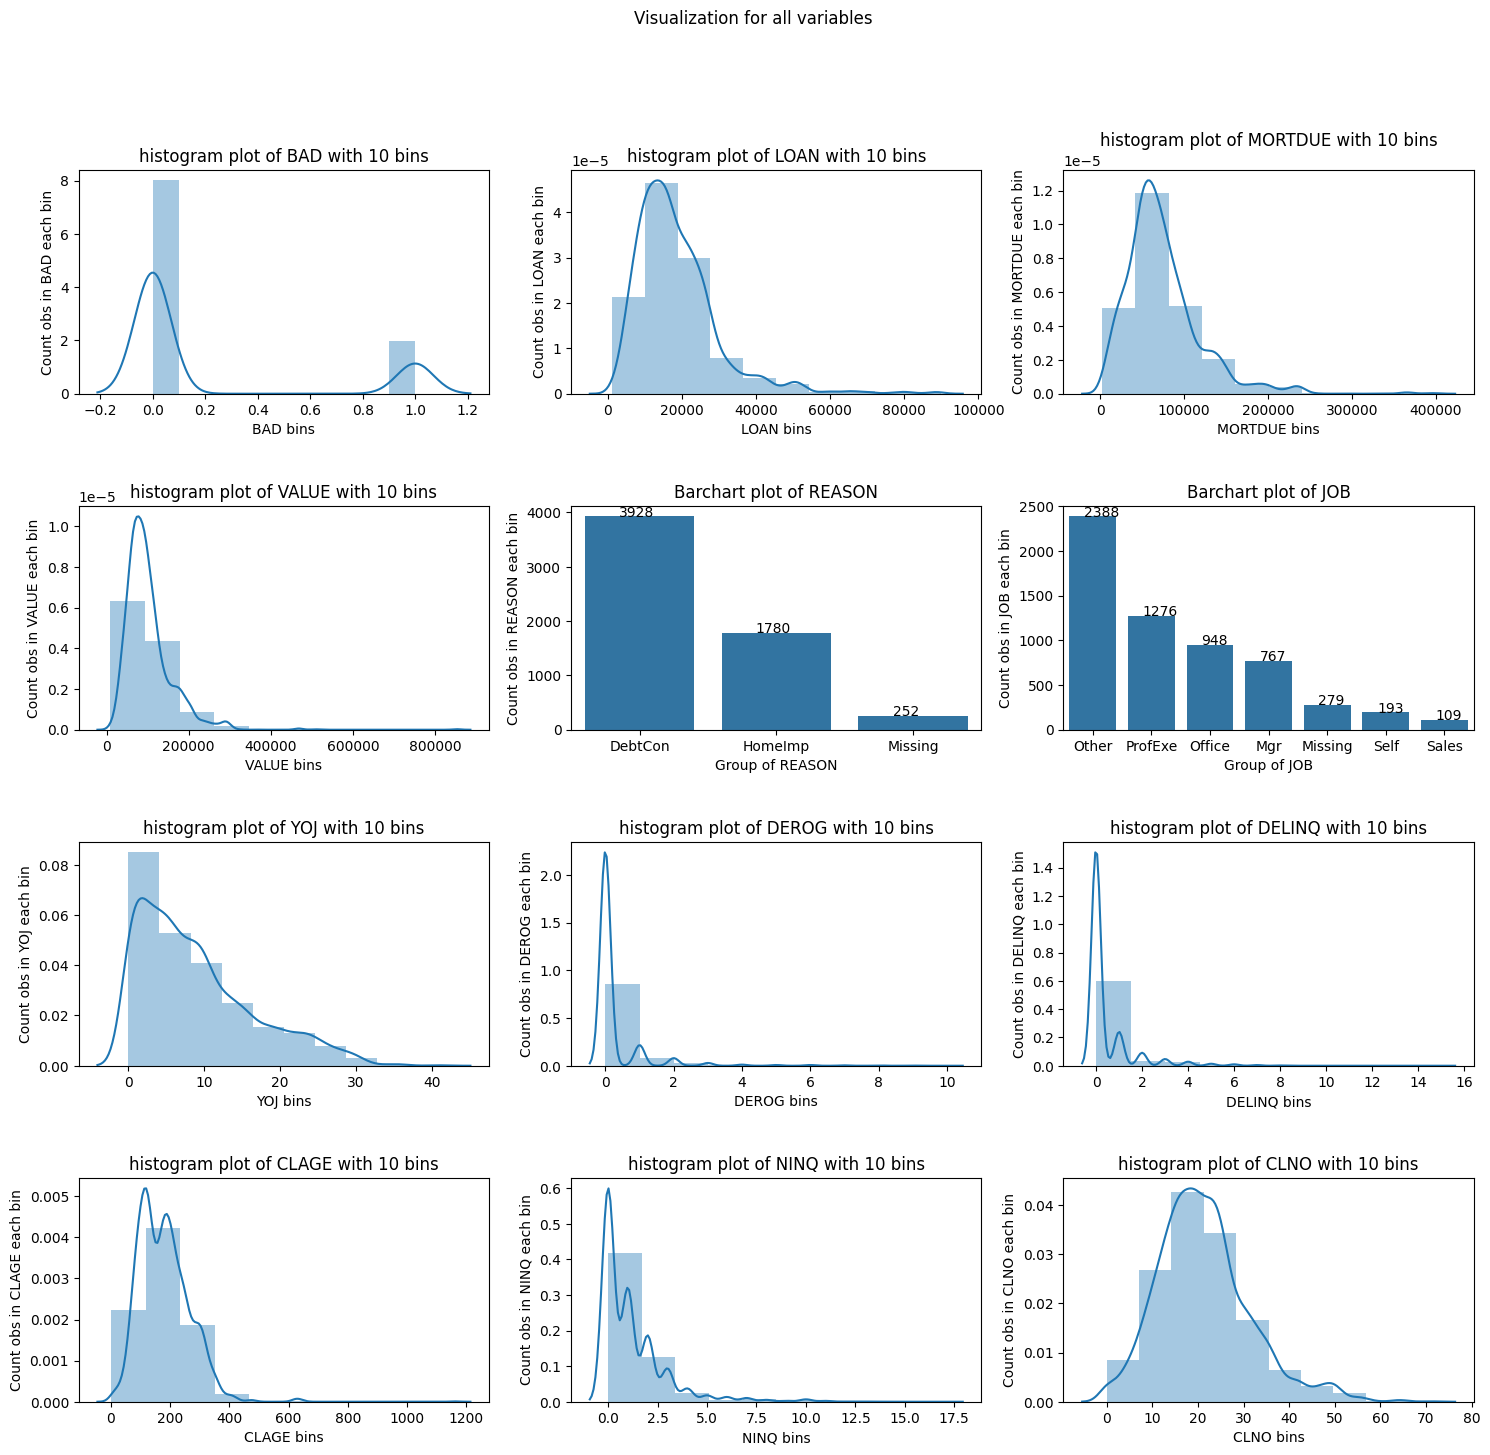

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return ax

# Barchart
def _plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)
  # Creating a for loop that takes the coordinates of the graph's vertices and adds labels via annotate.
  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return ax

# Initializing graph (Size W*H = 16x12) with distance between graphs being 0.2
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
# Create a for loop to check datatype of variables and visualize
for i, (fieldname, dtype) in enumerate(zip(data.columns, data.dtypes.values)):
  if i <= 11:
    ax_i = fig.add_subplot(4, 3, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = _plot_hist_subplot(data[fieldname], fieldname=fieldname)
    else:
      ax_i = _plot_barchart_subplot(data[fieldname], fieldname=fieldname)
      
fig.suptitle('Visualization for all variables')
plt.show()

<span style="color:red">
    <ul>Overview:</ul>
        <li>Skewness: Many numerical variables exhibit right-skewness, which is common in financial data.</li>
        <li>Imbalance: The "BAD" variable shows a significant class imbalance, with far more "good" cases than "bad" cases.</li>
        <li>Categorical Dominance: The "REASON" variable is dominated by one category ("DebtCon").</li>
        <li>Missing Values: "Missing" categories are present in both REASON and JOB, indicating potential data quality issues.</li>
</span>

### 2. Applying WOE

In [71]:
# Missing data processing
# Numeric variables
columns_num = data.select_dtypes(['float', 'int']).columns
data[columns_num] = data[columns_num].apply(lambda x: x.fillna(x.mean()), axis=0)

# Categorical variables
columns_obj = data.select_dtypes(['object']).columns
data[columns_obj] = data[columns_obj].apply(lambda x: x.fillna('Missing'), axis=0)

In [72]:
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0000,39025.000000,HomeImp,Other,10.500000,0.00000,0.000000,94.366667,1.000000,9.000000,33.779915
1,1,1300,70053.0000,68400.000000,HomeImp,Other,7.000000,0.00000,2.000000,121.833333,0.000000,14.000000,33.779915
2,1,1500,13500.0000,16700.000000,HomeImp,Other,4.000000,0.00000,0.000000,149.466667,1.000000,10.000000,33.779915
3,1,1500,73760.8172,101776.048741,Missing,Missing,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,0,1700,97800.0000,112000.000000,HomeImp,Office,3.000000,0.00000,0.000000,93.333333,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0000,90185.000000,DebtCon,Other,16.000000,0.00000,0.000000,221.808718,0.000000,16.000000,36.112347
5956,0,89000,54576.0000,92937.000000,DebtCon,Other,16.000000,0.00000,0.000000,208.692070,0.000000,15.000000,35.859971
5957,0,89200,54045.0000,92924.000000,DebtCon,Other,15.000000,0.00000,0.000000,212.279697,0.000000,15.000000,35.556590
5958,0,89800,50370.0000,91861.000000,DebtCon,Other,14.000000,0.00000,0.000000,213.892709,0.000000,16.000000,34.340882


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Binning function in terms of numeric and categorical variables
MAX_VAL = 999999999
MIN_VAL = -MAX_VAL

def _bin_table(data, colname, n_bins = 10, qcut = None):
  X = data[[colname, 'BAD']]
  X = X.sort_values(colname)
  coltype = X[colname].dtype

  if coltype in ['float', 'int']:
    if qcut is None:
      try:
        bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
        # Replacing threshold (start & end point) of thres
        thres[0] = MIN_VAL
        thres[-1] = MAX_VAL
        bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
        X['bins'] = bins
      except:
        print('Error: n_bins must be lower than the no of bin interval!')
    else:
      bins, thres = pd.cut(X[colname], bins=qcut, retbins=True)
      X['bins'] = bins
  elif coltype == 'object':
    X['bins'] = X[colname]

  df_GB = pd.pivot_table(X, 
                index = ['bins'],
                values = ['BAD'],
                columns = ['BAD'],
                aggfunc = {
                    'BAD':np.size
                })

  df_Count = pd.pivot_table(X, 
                index = ['bins'],
                values = ['BAD'],
                aggfunc = {
                    'BAD': np.size
                })
  
  if coltype in ['float', 'int']:
    df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
  elif coltype == 'object':
    df_Thres = pd.DataFrame(index=df_GB.index)
    thres = None
  df_Count.columns = ['No_Obs']
  df_GB.columns = ['#BAD', '#GOOD']
  df_summary = df_Thres.join(df_Count).join(df_GB)
  return df_summary, thres

In [74]:
# Binning based on cutoffs - Categorical variable
df_summary, thres = _bin_table(data, 'DELINQ', qcut=[MIN_VAL, 2, MAX_VAL])
df_summary

/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


,Thres,No_Obs,#BAD,#GOOD
bins,,,,
"(-999999999, 2]",2,5663,4674,989
"(2, 999999999]",999999999,297,97,200


In [75]:
# Binning based on cutoffs - Numeric variable
df_summary, thres = _bin_table(data, 'DEBTINC', n_bins=5)
df_summary

/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


,Thres,No_Obs,#BAD,#GOOD
bins,,,,
"(-999999999.0, 29.214]",2.921447e+01,1192,1127,65
"(29.214, 33.78]",3.377992e+01,2156,1316,840
"(33.78, 34.688]",3.468780e+01,228,216,12
"(34.688, 38.956]",3.895595e+01,1192,1102,90
"(38.956, 999999999.0]",1.000000e+09,1192,1010,182


In [76]:
# Creating WOE fuction
def _WOE(data, colname, n_bins = None, min_obs = 100, qcut = None):
  # Getting bins và initial thresholds
  df_summary, thres = _bin_table(data, colname, n_bins = n_bins, qcut = qcut)
  # Replace the 0 value of #BAD in df_summary with 1 to avoid division by zero error
  df_summary['#BAD'] = df_summary['#BAD'].replace({0:1})
  
  if qcut is not None:
    # Filter out threshold to create new threshold that satisfies number of observations >= min_obs
    exclude_ind = np.where(df_summary['No_Obs'] <= min_obs)[0]
    if exclude_ind.shape[0] > 0:
      new_thres = np.delete(thres, exclude_ind)
      print('Auto combine {} bins into {} bins'.format(n_bins, new_thres.shape[0]-1))
      # Recalculate df_summary
      df_summary, thres = _bin_table(data, colname, qcut=new_thres)
  
  new_thres = thres
  df_summary['GOOD/BAD'] = df_summary['#GOOD']/df_summary['#BAD']
  df_summary['%BAD'] = df_summary['#BAD']/df_summary['#BAD'].sum()
  df_summary['%GOOD'] = df_summary['#GOOD']/df_summary['#GOOD'].sum()
  df_summary['WOE'] = np.log(df_summary['%GOOD']/df_summary['%BAD'])
  df_summary['IV'] = (df_summary['%GOOD']-df_summary['%BAD'])*df_summary['WOE']
  df_summary['COLUMN'] = colname
  IV = df_summary['IV'].sum()
  print('Information Value of {} column: {}'.format(colname, IV))
  return df_summary, IV, new_thres

In [77]:
# Testing WOE, IV result for DEBTINC
df_summary, IV, thres = _WOE(data, 'DEBTINC', n_bins = 7, min_obs= 100)
df_summary

Information Value of DEBTINC column: 1.3795573580411762


/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,


,Thres,No_Obs,#BAD,#GOOD,GOOD/BAD,%BAD,%GOOD,WOE,IV,COLUMN
bins,,,,,,,,,,
"(-999999999.0, 27.028]",2.702826e+01,852,800,52,0.065000,0.167680,0.043734,-1.343925,0.166573,DEBTINC
"(27.028, 31.875]",3.187511e+01,851,808,43,0.053218,0.169357,0.036165,-1.543919,0.205637,DEBTINC
"(31.875, 33.78]",3.377992e+01,1645,835,810,0.970060,0.175016,0.681245,1.359046,0.687988,DEBTINC
"(33.78, 34.043]",3.404341e+01,58,56,2,0.035714,0.011738,0.001682,-1.942761,0.019535,DEBTINC
"(34.043, 37.18]",3.717985e+01,851,783,68,0.086845,0.164117,0.057191,-1.054182,0.112719,DEBTINC
"(37.18, 40.133]",4.013282e+01,851,804,47,0.058458,0.168518,0.039529,-1.450008,0.187035,DEBTINC
"(40.133, 999999999.0]",1.000000e+09,852,685,167,0.243796,0.143576,0.140454,-0.021982,0.000069,DEBTINC


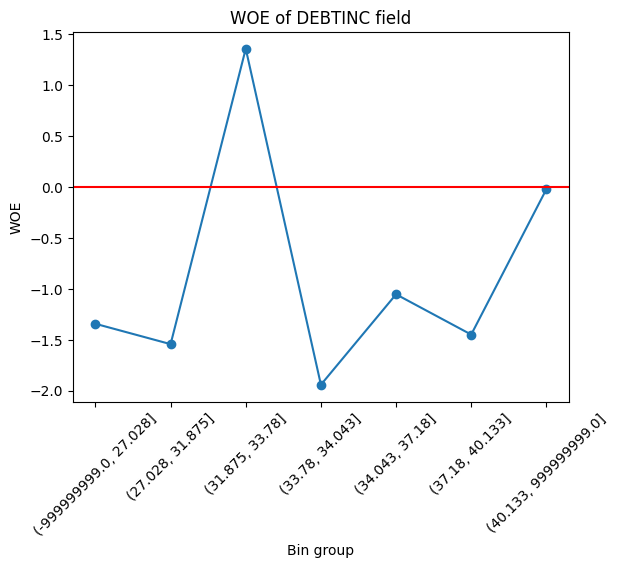

In [78]:
# Creating PLOT for WOE  - DEBTINC
def _plot(df_summary):
  colname = list(df_summary['COLUMN'].unique())[0]
  df_summary['WOE'].plot(linestyle='-', marker='o')
  plt.title('WOE of {} field'.format(colname))
  plt.axhline(y=0, color = 'red')
  plt.xticks(rotation=45)
  plt.ylabel('WOE')
  plt.xlabel('Bin group')

_plot(df_summary)

In [79]:
# Calculate IV for all variables
# For numeric variables
WOE_dict=dict()
nbins = {'LOAN': 10, 'MORTDUE': 10, 'VALUE': 10, 'YOJ':10, 'CLAGE':10, 'NINQ': 2, 'CLNO':10, 'DEBTINC':7}
for (col, bins) in nbins.items():
  df_summary, IV, thres = _WOE(data, colname=col, n_bins=bins)
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify 

Information Value of LOAN column: 0.1601563338988017
Information Value of MORTDUE column: 0.05131351983314017
Information Value of VALUE column: 0.14188912125986042
Information Value of YOJ column: 0.06714693781095009
Information Value of CLAGE column: 0.22171042878294653
Information Value of NINQ column: 0.06965935231976197
Information Value of CLNO column: 0.06043698467606807
Information Value of DEBTINC column: 1.3795573580411762


/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify 

In [80]:
WOE_dict

{'LOAN': {'table':                               Thres  No_Obs  #BAD  #GOOD  GOOD/BAD      %BAD  \
  bins                                                                           
  (-999999999.0, 7600.0]       7600.0     603   374    229  0.612299  0.078390   
  (7600.0, 10000.0]           10000.0     608   471    137  0.290870  0.098721   
  (10000.0, 12100.0]          12100.0     582   476    106  0.222689  0.099769   
  (12100.0, 14400.0]          14400.0     610   503    107  0.212724  0.105429   
  (14400.0, 16300.0]          16300.0     578   447    131  0.293065  0.093691   
  (16300.0, 18800.0]          18800.0     604   520     84  0.161538  0.108992   
  (18800.0, 21700.0]          21700.0     591   492     99  0.201220  0.103123   
  (21700.0, 25000.0]          25000.0     613   506    107  0.211462  0.106057   
  (25000.0, 30500.0]          30500.0     576   504     72  0.142857  0.105638   
  (30500.0, 999999999.0]  999999999.0     595   478    117  0.244770  0.100189   

In [81]:
# Since DEROG, DELINQ variables tend to be ordinal rather than continuous, using quantile partitioning will produce bins of length 0. 
# Therefore, the cutoff point will be applied for them.

for col in ['DEROG', 'DELINQ']:
  df_summary, IV, thres = _WOE(data, colname=col, n_bins=5, qcut=[MIN_VAL, 2, MAX_VAL])
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of DEROG column: 0.19008112833205368
Information Value of DELINQ column: 0.3366699247263777


/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_Count = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_GB = pd.pivot_table(X,
/tmp/ipykernel_1828/1919369800.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify 

In [82]:
# Calculating IV for REASON and JOB variables
for col in ['REASON', 'JOB']:
  df_summary, IV, thres = _WOE(data, colname=col)
  WOE_dict[col] = {'table':df_summary, 'IV':IV}

Information Value of REASON column: 0.008618460238864025
Information Value of JOB column: 0.1237305657142077


In [83]:
# Estimating predictive power of variables
columns = []
IVs = []
for col in data.columns:
  if col != 'BAD':
    columns.append(col)
    IVs.append(WOE_dict[col]['IV'])
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})

def _rank_IV(iv):
  if iv <= 0.02:
    return 'Unpredictive'
  elif iv <= 0.1:
    return 'Weak'
  elif iv <= 0.3:
    return 'Medium'
  elif iv <= 0.5:
    return 'Strong'
  else:
    return 'Suspicious'

df_WOE['rank']=df_WOE['IV'].apply(lambda x: _rank_IV(x))
df_WOE.sort_values('IV', ascending=False)


,column,IV,rank
11,DEBTINC,1.379557,Suspicious
7,DELINQ,0.336670,Strong
8,CLAGE,0.221710,Medium
6,DEROG,0.190081,Medium
0,LOAN,0.160156,Medium
2,VALUE,0.141889,Medium
4,JOB,0.123731,Medium
9,NINQ,0.069659,Weak
5,YOJ,0.067147,Weak
10,CLNO,0.060437,Weak


<span style="color:red">
    <ul>Overview:</ul>
        <li>Most variavles have some degree of support for this classification, except for "REASON"</li>
        <li>The strongest variables are "DELINQ" and "DEBTINC", but "DEBTINC" should be checked for overpredicting as IV >= 0.5</li>
        <li>"CLAGE", "DEROG", "LOAN", "VALUE", and "JOB" have medium predictive power.</li>
        <li>The remaining variables, including "NINQ", "YOJ", "CLNO", and "MORTDUE", also have classification power, but they are weaker.</li>
</span>

### 3. Logistic Regression

In [84]:
for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['WOE'].index)
    woe = list(WOE_dict[col]['table']['WOE'])
    d = dict(zip(key, woe))
    col_woe = col+'_WOE'
    data[col_woe] = data[col].map(d)
  except:
    print(col)

In [85]:
# Assigning the input values as WOE variables and the target variable as data[‘BAD’]
X = data.filter(like='_WOE', axis = 1)
Y = data['BAD']

In [86]:
X

,LOAN_WOE,MORTDUE_WOE,VALUE_WOE,YOJ_WOE,CLAGE_WOE,NINQ_WOE,CLNO_WOE,DEBTINC_WOE,DEROG_WOE,DELINQ_WOE,REASON_WOE,JOB_WOE
0,0.898910,0.403995,0.630114,0.094209,0.386975,-0.210721,0.484269,1.359046,-0.078161,-0.163633,0.138124,0.192353
1,0.898910,-0.025653,-0.224027,-0.129023,0.288596,-0.210721,-0.170345,1.359046,-0.078161,-0.163633,0.138124,0.192353
2,0.898910,0.403995,0.630114,0.288849,0.302004,-0.210721,0.484269,1.359046,-0.078161,-0.163633,0.138124,0.192353
3,0.898910,-0.356854,0.559662,-0.027355,0.032257,0.332504,0.048611,1.359046,-0.078161,-0.163633,-0.057476,-1.020240
4,0.898910,-0.096285,0.559662,0.288849,0.386975,-0.210721,-0.170345,1.359046,-0.078161,-0.163633,0.138124,-0.495199
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,-0.017993,0.001050,-0.527866,0.060778,-0.311344,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353
5956,-0.017993,0.001050,-0.527866,0.060778,-0.431992,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353
5957,-0.017993,0.001050,-0.527866,0.060778,-0.311344,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353
5958,-0.017993,-0.063186,-0.527866,0.094209,-0.311344,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353


In [87]:
# Splitting the sample data set into train/test sets with a sample size ratio of 80:20. 
# The ratio of GOOD/BAD is balanced on both train and test.

from sklearn.model_selection import train_test_split

ids = np.arange(X.shape[0])
X_train, X_test, Y_train, Y_test, id_train, id_test = train_test_split(X, Y, ids, test_size = 0.2, stratify = Y, shuffle = True, random_state = 123)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_train shape: ', Y_train.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (4768, 12)
X_test shape:  (1192, 12)
Y_train shape:  (4768,)
Y_test shape:  (1192,)


In [88]:
from sklearn.linear_model import LogisticRegression

logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000, fit_intercept=True, tol=0.0001, C=1, penalty='l2')
logit_model.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1, max_iter=1000, multi_class='auto')

### 4. Checkingthe performance of model

In [89]:
# Checking acccuracy on train/test sets
from sklearn.metrics import accuracy_score

y_pred_train = logit_model.predict(X_train)
acc_train = accuracy_score(y_pred_train, Y_train)
y_pred_test = logit_model.predict(X_test)
acc_test = accuracy_score(y_pred_test, Y_test)

print('accuracy on train: ', acc_train)
print('accuracy on test: ', acc_test)

accuracy on train:  0.8651426174496645
accuracy on test:  0.8557046979865772


<span style="color:red">
    <ul>The model has high accuracy with over 85%</ul>
</span>

/tmp/ipykernel_1828/2707060085.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
/tmp/ipykernel_1828/2707060085.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)


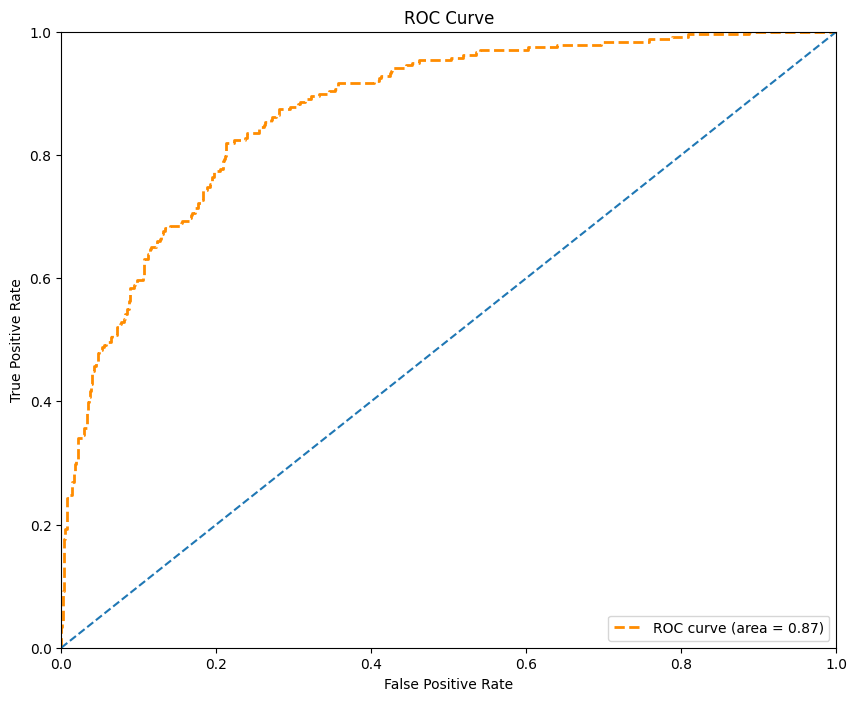

In [90]:
# ROC curve for test set
from sklearn.metrics import roc_curve, auc

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
fpr, tpr, thres = roc_curve(Y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

_plot_roc_curve(fpr, tpr, thres, roc_auc)

<span style="color:red">
        <li>The AUC (area under curve) index measures the area under the ROC curve, indicating whether the classification ability of the logistic regression model for GOOD/BAD cases is strong or weak.</li>
        <li>The larger AUC, the better the model.</li>
        <li>For this logistic regression model, AUC = 0.87 is quite high, indicating that the model's predictive ability is good and the model can be applied in practice.</li>
</span>

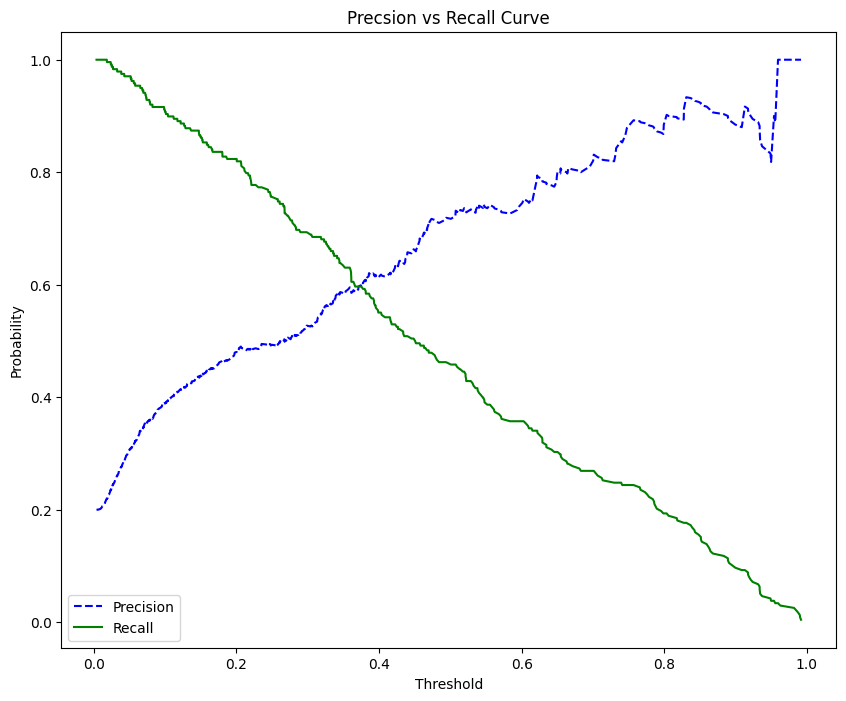

In [91]:
# Precision and recall curve for test set
from sklearn.metrics import precision_recall_curve
precision, recall, thres = precision_recall_curve(Y_test, y_pred_prob_test)

def _plot_prec_rec_curve(prec, rec, thres):
    plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()

_plot_prec_rec_curve(precision, recall, thres)

In [92]:
from sklearn.metrics import recall_score
y_pred_train = logit_model.predict(X_train)
recall_train = recall_score(y_pred_train, Y_train)
y_pred_test = logit_model.predict(X_test)
recall_test = recall_score(y_pred_test, Y_test)

print('recall on train: ', recall_train)
print('recall on test: ', recall_test)

recall on train:  0.7383900928792569
recall on test:  0.7171052631578947


<span style="color:red">
    <ul>high recall value in both train and test sets with over 71%</ul>
</span>

In [93]:
from sklearn.metrics import precision_score
y_pred_train = logit_model.predict(X_train)
precision_train = precision_score(y_pred_train, Y_train)
y_pred_test = logit_model.predict(X_test)
precision_test = precision_score(y_pred_test, Y_test)

print('precision on train: ', precision_train)
print('precision on test: ', precision_test)

precision on train:  0.501577287066246
precision on test:  0.4579831932773109


<span style="color:red">
    <ul>Not very high precision value in both train and test sets around 50%</ul>
</span>

### 5. Calculating Credit Score

In [94]:
import numpy as np

# Definig Credit score function
def _CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

#Testing
_CreditScore(beta = 0.5, alpha = -1, woe = 0.15, n = 12)

np.float64(42.2677896003704)

In [95]:
# Inputing beta and alpha values of the model
betas_dict = dict(zip(list(X_train.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

{'LOAN_WOE': np.float64(0.47130951127303766),
 'MORTDUE_WOE': np.float64(0.5762156108284979),
 'VALUE_WOE': np.float64(0.7544143186283644),
 'YOJ_WOE': np.float64(0.8882202429315134),
 'CLAGE_WOE': np.float64(0.8619945897188416),
 'NINQ_WOE': np.float64(0.5435907031477423),
 'CLNO_WOE': np.float64(0.8534171898432041),
 'DEBTINC_WOE': np.float64(0.9446689004675842),
 'DEROG_WOE': np.float64(0.9000364399706491),
 'DELINQ_WOE': np.float64(1.0553901608265084),
 'REASON_WOE': np.float64(0.6427430371047437),
 'JOB_WOE': np.float64(0.8915099587930929)}

In [96]:
#Calculating WOE for variables
cols = []
features = []
woes = []
betas = []
scores = []

for col in columns:
  for feature, woe in WOE_dict[col]['table']['WOE'].to_frame().iterrows():
      cols.append(col)
      # Add feature
      feature = str(feature)
      features.append(feature)    
      # Add woe
      woe = woe.values[0]
      woes.append(woe)
      # Add beta
      col_woe = col+'_WOE'
      beta = betas_dict[col_woe]
      betas.append(beta)
      # Add score
      score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = 12)
      scores.append(score)

df_WOE = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
df_WOE

,Columns,Features,WOE,Betas,Scores
0,LOAN,"(-999999999.0, 7600.0]",0.898910,0.471310,19.433161
1,LOAN,"(7600.0, 10000.0]",0.154566,0.471310,44.739194
2,LOAN,"(10000.0, 12100.0]",-0.112535,0.471310,53.820059
3,LOAN,"(12100.0, 14400.0]",-0.158318,0.471310,55.376566
4,LOAN,"(14400.0, 16300.0]",0.162082,0.471310,44.483670
...,...,...,...,...,...
78,DEBTINC,"(31.875, 33.78]",1.359046,0.944669,-42.615979
79,DEBTINC,"(33.78, 34.043]",-1.942761,0.944669,182.380566
80,DEBTINC,"(34.043, 37.18]",-1.054182,0.944669,121.829686
81,DEBTINC,"(37.18, 40.133]",-1.450008,0.944669,148.802684


In [97]:
# Pick a random case
test_obs = data[columns].iloc[0:1, :]
test_obs

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,33.779915


In [98]:
# Calculating score for each dimension of the random case
def _search_score(obs, col):
  feature = [str(inter) for inter in list(WOE_dict[col]['table'].index) if obs[col].values[0] in inter][0]
  score = df_WOE[(df_WOE['Columns'] == col) & (df_WOE['Features'] == feature)]['Scores'].values[0]
  return score

# Calculating score for 'LOAN' variable of test_obs
score = _search_score(test_obs, 'LOAN')
score

np.float64(19.4331607677984)

In [99]:
# Score details of the random case
def _total_score(obs, columns = columns):
  scores = dict()
  for col in columns:
    scores[col] = _search_score(obs, col)
  total_score = sum(scores.values())
  return scores, total_score

scores, total_score = _total_score(test_obs)
print('score for each variables: \n', scores)
print('final total score: ', total_score)

score for each variables: 
 {'LOAN': np.float64(19.4331607677984), 'MORTDUE': np.float64(33.20197643021535), 'VALUE': np.float64(15.703607488443478), 'REASON': np.float64(43.59008786507132), 'JOB': np.float64(37.62407970790302), 'YOJ': np.float64(43.95799113028173), 'DEROG': np.float64(55.06861409165744), 'DELINQ': np.float64(62.45152301441897), 'CLAGE': np.float64(25.932094412371285), 'NINQ': np.float64(58.25684625589339), 'CLNO': np.float64(20.181974254729187), 'DEBTINC': np.float64(-42.615979112535406)}
final total score:  372.7859763062482


In [100]:
# Credit score for the data sample
total_scores = []
for i in np.arange(data[columns].shape[0]):
  obs = data[columns].iloc[i:(i+1), :]
  _, score = _total_score(obs)
  total_scores.append(score)
data['Score'] = total_scores

In [101]:
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,YOJ_WOE,CLAGE_WOE,NINQ_WOE,CLNO_WOE,DEBTINC_WOE,DEROG_WOE,DELINQ_WOE,REASON_WOE,JOB_WOE,Score
0,1,1100,25860.0000,39025.000000,HomeImp,Other,10.500000,0.00000,0.000000,94.366667,...,0.094209,0.386975,-0.210721,0.484269,1.359046,-0.078161,-0.163633,0.138124,0.192353,372.785976
1,1,1300,70053.0000,68400.000000,HomeImp,Other,7.000000,0.00000,2.000000,121.833333,...,-0.129023,0.288596,-0.210721,-0.170345,1.359046,-0.078161,-0.163633,0.138124,0.192353,497.844976
2,1,1500,13500.0000,16700.000000,HomeImp,Other,4.000000,0.00000,0.000000,149.466667,...,0.288849,0.302004,-0.210721,0.484269,1.359046,-0.078161,-0.163633,0.138124,0.192353,365.598543
3,1,1500,73760.8172,101776.048741,Missing,Missing,8.922268,0.25457,0.449442,179.766275,...,-0.027355,0.032257,0.332504,0.048611,1.359046,-0.078161,-0.163633,-0.057476,-1.020240,530.657861
4,0,1700,97800.0000,112000.000000,HomeImp,Office,3.000000,0.00000,0.000000,93.333333,...,0.288849,0.386975,-0.210721,-0.170345,1.359046,-0.078161,-0.163633,0.138124,-0.495199,469.457738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0000,90185.000000,DebtCon,Other,16.000000,0.00000,0.000000,221.808718,...,0.060778,-0.311344,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353,743.344964
5956,0,89000,54576.0000,92937.000000,DebtCon,Other,16.000000,0.00000,0.000000,208.692070,...,0.060778,-0.431992,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353,750.846801
5957,0,89200,54045.0000,92924.000000,DebtCon,Other,15.000000,0.00000,0.000000,212.279697,...,0.060778,-0.311344,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353,743.344964
5958,0,89800,50370.0000,91861.000000,DebtCon,Other,14.000000,0.00000,0.000000,213.892709,...,0.094209,-0.311344,-0.210721,-0.170345,-1.054182,-0.078161,-0.163633,-0.062752,0.192353,743.872971


/tmp/ipykernel_1828/1924059264.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Score'])
/tmp/ipykernel_1828/1924059264.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['BAD']==1]['Score'], label='Default')
/tmp/ipykernel_1828/1924059264.py:8: UserWarning: 

`distplot` is a

Text(0.5, 1.0, 'Distribution Score in Default vs Non-Default')

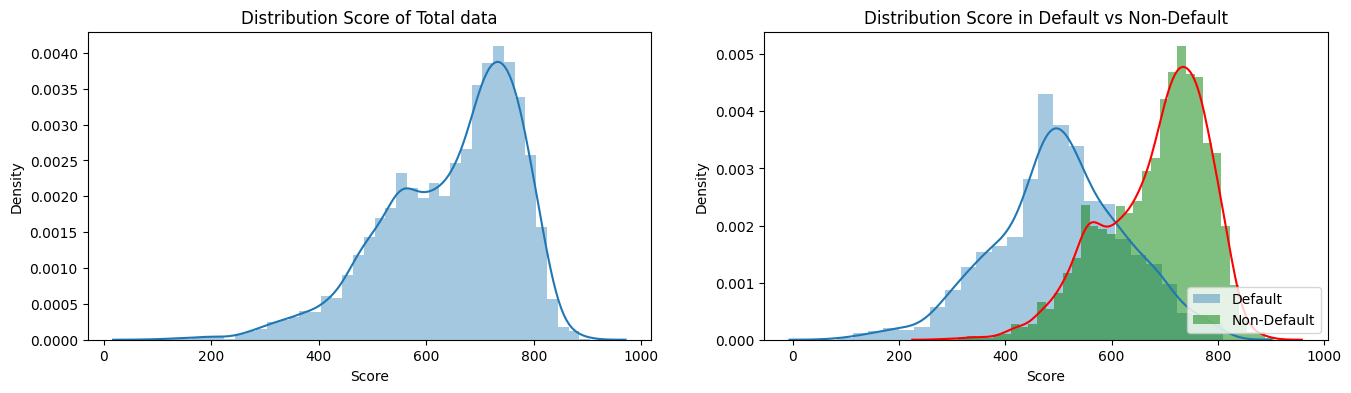

In [102]:
# Distribution chart based on credit score in terms of GOOD and BAD
plt.figure(figsize=(16, 4))
plt.subplot(121)
sns.distplot(data['Score'])
plt.title('Distribution Score of Total data')
plt.subplot(122)
sns.distplot(data[data['BAD']==1]['Score'], label='Default')
sns.distplot(data[data['BAD']==0]['Score'], label='Non-Default', 
             kde_kws={"color": "r"}, 
             hist_kws={"color": "g", "alpha":0.5})
plt.legend(loc = 'lower right')
plt.title('Distribution Score in Default vs Non-Default')

<span style="color:red">
    <li>Overall, the range of scores appears to be wide, indicating a significant spread in the data..</li>    
    <li>There's a clear separation between the default and non-default distributions, indicating that the score effectively discriminates between the two groups.</li>
        
</span>